In [1]:
import os,glob
import pandas as pd
import pygmt
import pickle
import warnings  
warnings.filterwarnings("ignore")

In [42]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '14p,Times-Roman',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')


def PygmtBegin(figmap, region, title):
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', f'nSeW+t"{title}"'])
    grdpath = '/Volumes/home/Research/GMT/LithoThickness'
    figmap.grdimage(f'{grdpath}/area_masked.grd',region =region, cmap=f'{grdpath}/Lith.cpt', transparency=30)
    figmap.grdcontour(f'{grdpath}/area_masked.grd',limit=[50,150],interval='10+e10p',annotation=20)

    # figmap.grdimage('@earth_relief_15s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)

    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p,--')
    figmap.colorbar(cmap=f'{grdpath}/Lith.cpt',position='x9.3c/14.6c+w5c/0.3c+h+ml',frame=['a20f10', 'x+l"Lithosphre Thickness"', "y+lkm"]) 

    legenddata=[[45.1, 42.8, 0, 5, 0.5*40],[45.9, 42.8, 0, 5, 1*40],[46.9, 42.8, 0, 5, 1.5*40]]
    figmap.plot(data=legenddata, style="J", color="black", pen="0.01p,black", no_clip=True)
    figmap.text(x=45.1,y=43.,text='0.5s', font="10p,Times-Bold,black", no_clip=True)
    figmap.text(x=45.9,y=43.,text='1s', font="10p,Times-Bold,black", no_clip=True)
    figmap.text(x=46.9,y=43.,text='1.5s', font="10p,Times-Bold,black", no_clip=True) 
    #     figmap.plot(data=smooth_fault,pen='1p,brown')
#     Volcano = '/Volumes/home/Research/DataBase/01_Armenia/02_Volcano_list.csv'
#     dv = pd.read_csv(Volcano)
#     figmap.plot(x=dv['lon'],y=dv['lat'],style="kvolcano/0.4c", pen='0.1p,black', color="black")
    
def PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep):
        
    cmd = """
    taup pierce -mod iasp91 -h %(evdep)f -sta %(stlat)f %(stlon)f -evt %(evlat)f %(evlon)f -ph %(phase)s --pierce %(PierceDep)f -nodiscon  > temp.txt
    """ % locals()
    os.system(cmd)

    if evdep > PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==2 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])
    elif evdep <= PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==3 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])  
    
    return p_lon, p_lat

colorcmp = 'relative_ref45.cpt'
dcolor = pd.read_csv(colorcmp, sep='\s+', names = ['begin', 'color1', 'end', 'color2','q'])
def find_relcolor(phi):
    if phi<=-70: phi = 180+phi
    
    colorphi = phi - 45
    for i in range(6):
        begin = float(dcolor['begin'].values[i])
        end   = float(dcolor['end'].values[i])
        if begin <= colorphi < end: 
            if abs(begin-colorphi) < abs(end-colorphi):
                color_ = dcolor['color1'].values[i]
            else:
                color_ = dcolor['color2'].values[i]
        elif colorphi < -32:
            color_ = '255'#'99/184/255'
        elif colorphi >= 32:
            if colorcmp == 'relative_ref45.cpt': 
                color_ = '50'
            else:
                color_ = '255'

    return color_


In [3]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
path    = '/Volumes/home/Research/STEP/02_Station_result_csv'
figpath = '/Volumes/home/Research/STEP/12_PiercePoint'
smooth_fault='/Volumes/home/Research/DataBase/01_Armenia/00_smooth_fault_7.txt'
Afault='/Volumes/home/Research/DataBase/01_Armenia/00_A_fault_20220624.txt'
method = 'SC'

==================IU.GNI==================
==================AM.ALAV==================
==================AM.ARZA==================
==================AM.BAUR==================
==================AM.BYUR==================
==================AM.GERK==================
==================AM.KECH==================
==================AM.LICH==================
==================AM.MAGY==================
==================AM.NAVR==================
==================AM.SHEN==================
==================AM.TSAP==================
==================AM.VAND==================
==================AM.ZARN==================
==================KO.BCA==================
==================KO.TASB==================
==================GO.AKH==================
==================GO.BGD==================
==================GO.CHVG==================
==================GO.DGRG==================
==================GO.GUDG==================
==================GO.ONI==================
==================GO.SEAG============

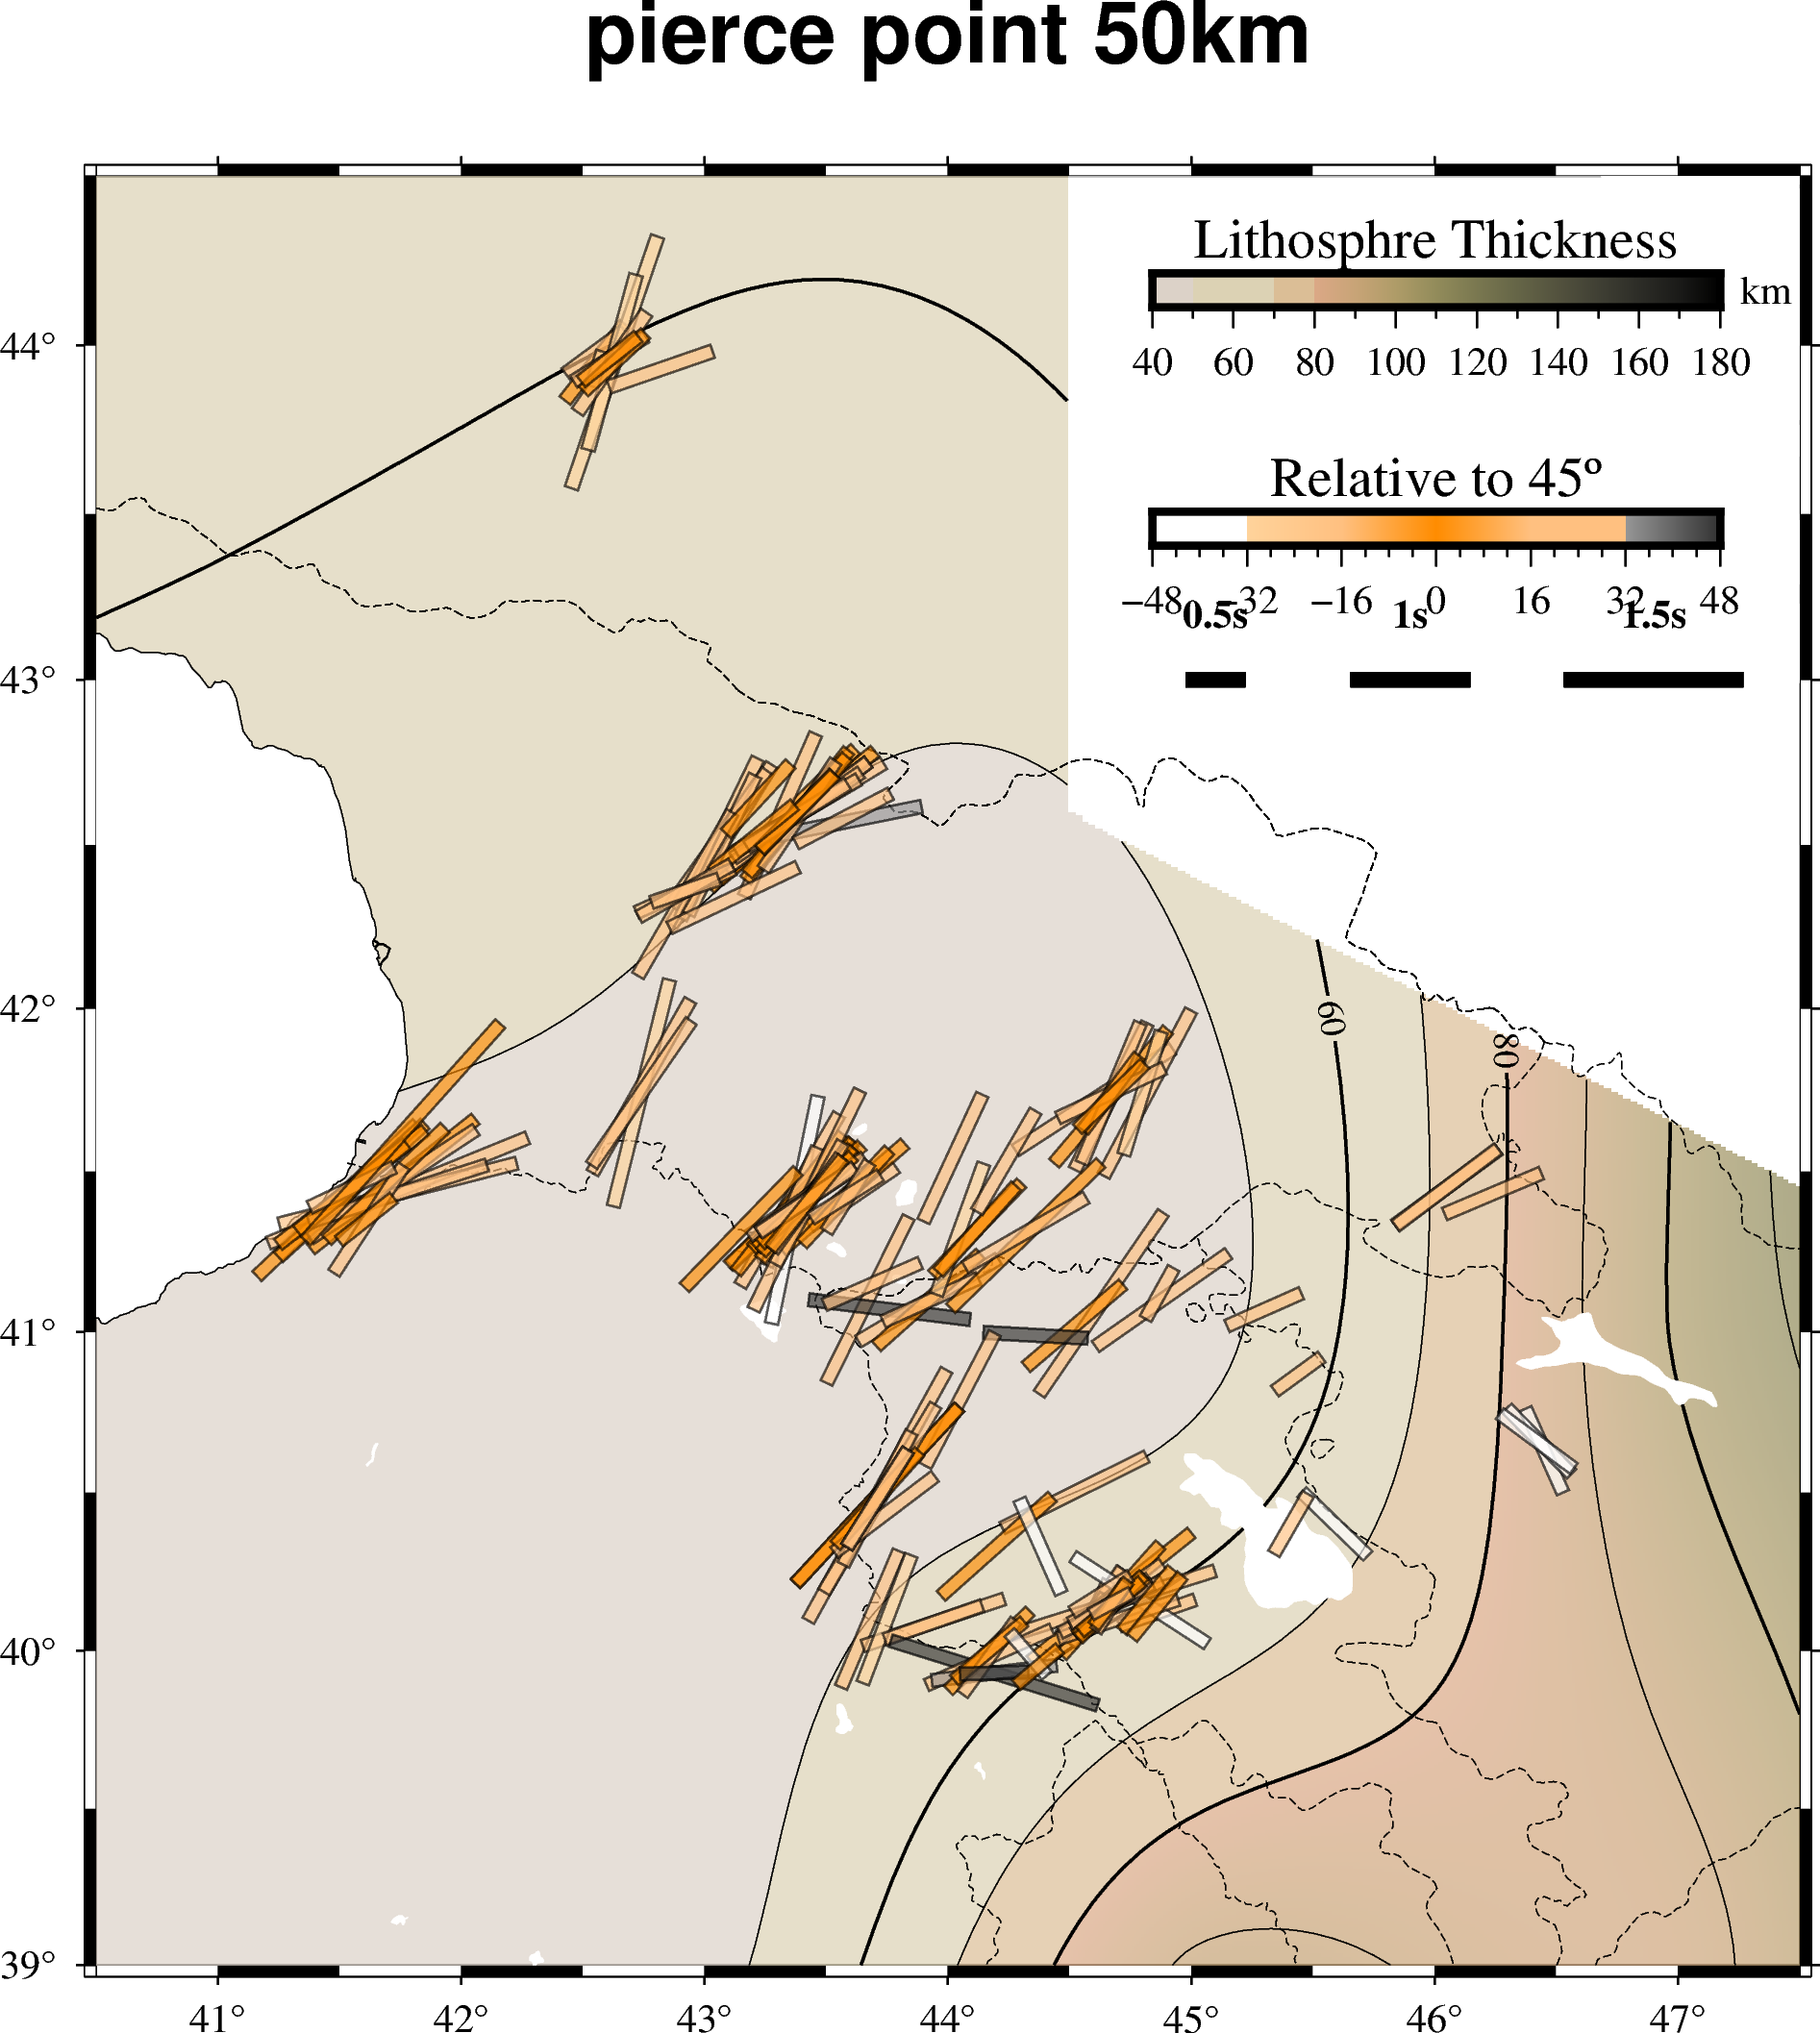

In [40]:
region = [40.5, 47.5, 39, 44.5] ##for all
fig = 'All'


for PierceDep in [50]:
    PPdf = {'Station':[],
       'Event':[],
       'plon':[],
       'plat':[],
       'phi':[],
       'dt':[]}
    figmap = pygmt.Figure()
    title = f"pierce point {PierceDep}km"
    PygmtBegin(figmap,region,title)
    figmap.colorbar(cmap=colorcmp, position="x9.3c/12.5c+w5c/0.3c+h+ml", frame=['a16f4+l"Relative to 45\\353"'] )

    for NET in ['IU','AM','KO','GO','TG','AB','II']:
        for pkl in sorted(glob.glob(f'{PKLpath}/{NET}*.pkl')):
            STApkl = pickle.load(open(pkl, "rb"))
            values = [value for keys, value in STApkl.items() ][0]
            sta = values['station']
            stlat = values['latitude']; stlon = values['longitude']

            print(f'=================={NET}.{sta}==================')

            for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify_220913/{NET}.{sta}*result_v2.csv')):
                df = pd.read_csv(resultpath)
                dff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]
                dff = dff.sort_values(by=['SCdt'], ascending=False)
                  
                for i in range(len(dff)):
                    event = dff['Event'].values[i]
                    evlat = dff['Ev_lat'].values[i]
                    evlon = dff['Ev_lon'].values[i]
                    evdep = dff['Depth'].values[i]
                    phase = dff['Phase'].values[i]

                    phi = dff['SCPhi'].values[i]
                    dt  = dff['SCdt'].values[i]
                    cc = find_relcolor(phi)     
                    p_lon, p_lat = PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep)
                    data = [[p_lon, p_lat, phi-90, 4.5, dt*40]]
                    figmap.plot(data=data, style="J", color=cc, pen="0.5p,black",transparency=35, no_clip=True)
                    
                    PPdf['Station'].append(sta)
                    PPdf['Event'].append(event)
                    PPdf['plon'].append(p_lon)
                    PPdf['plat'].append(p_lat)                    
                    PPdf['phi'].append(phi)
                    PPdf['dt'].append(dt)                     
    figmap.show()
    PPdf = pd.DataFrame(PPdf)
    PPdf.to_csv(f'PP_{PierceDep}.csv',index=False)
    figmap.savefig(f'Dep{PierceDep}_wLith_v0.png',dpi=200)
    figmap.savefig(f'Dep{PierceDep}_wLith_v0.pdf',dpi=200)
    
      
    
            

        

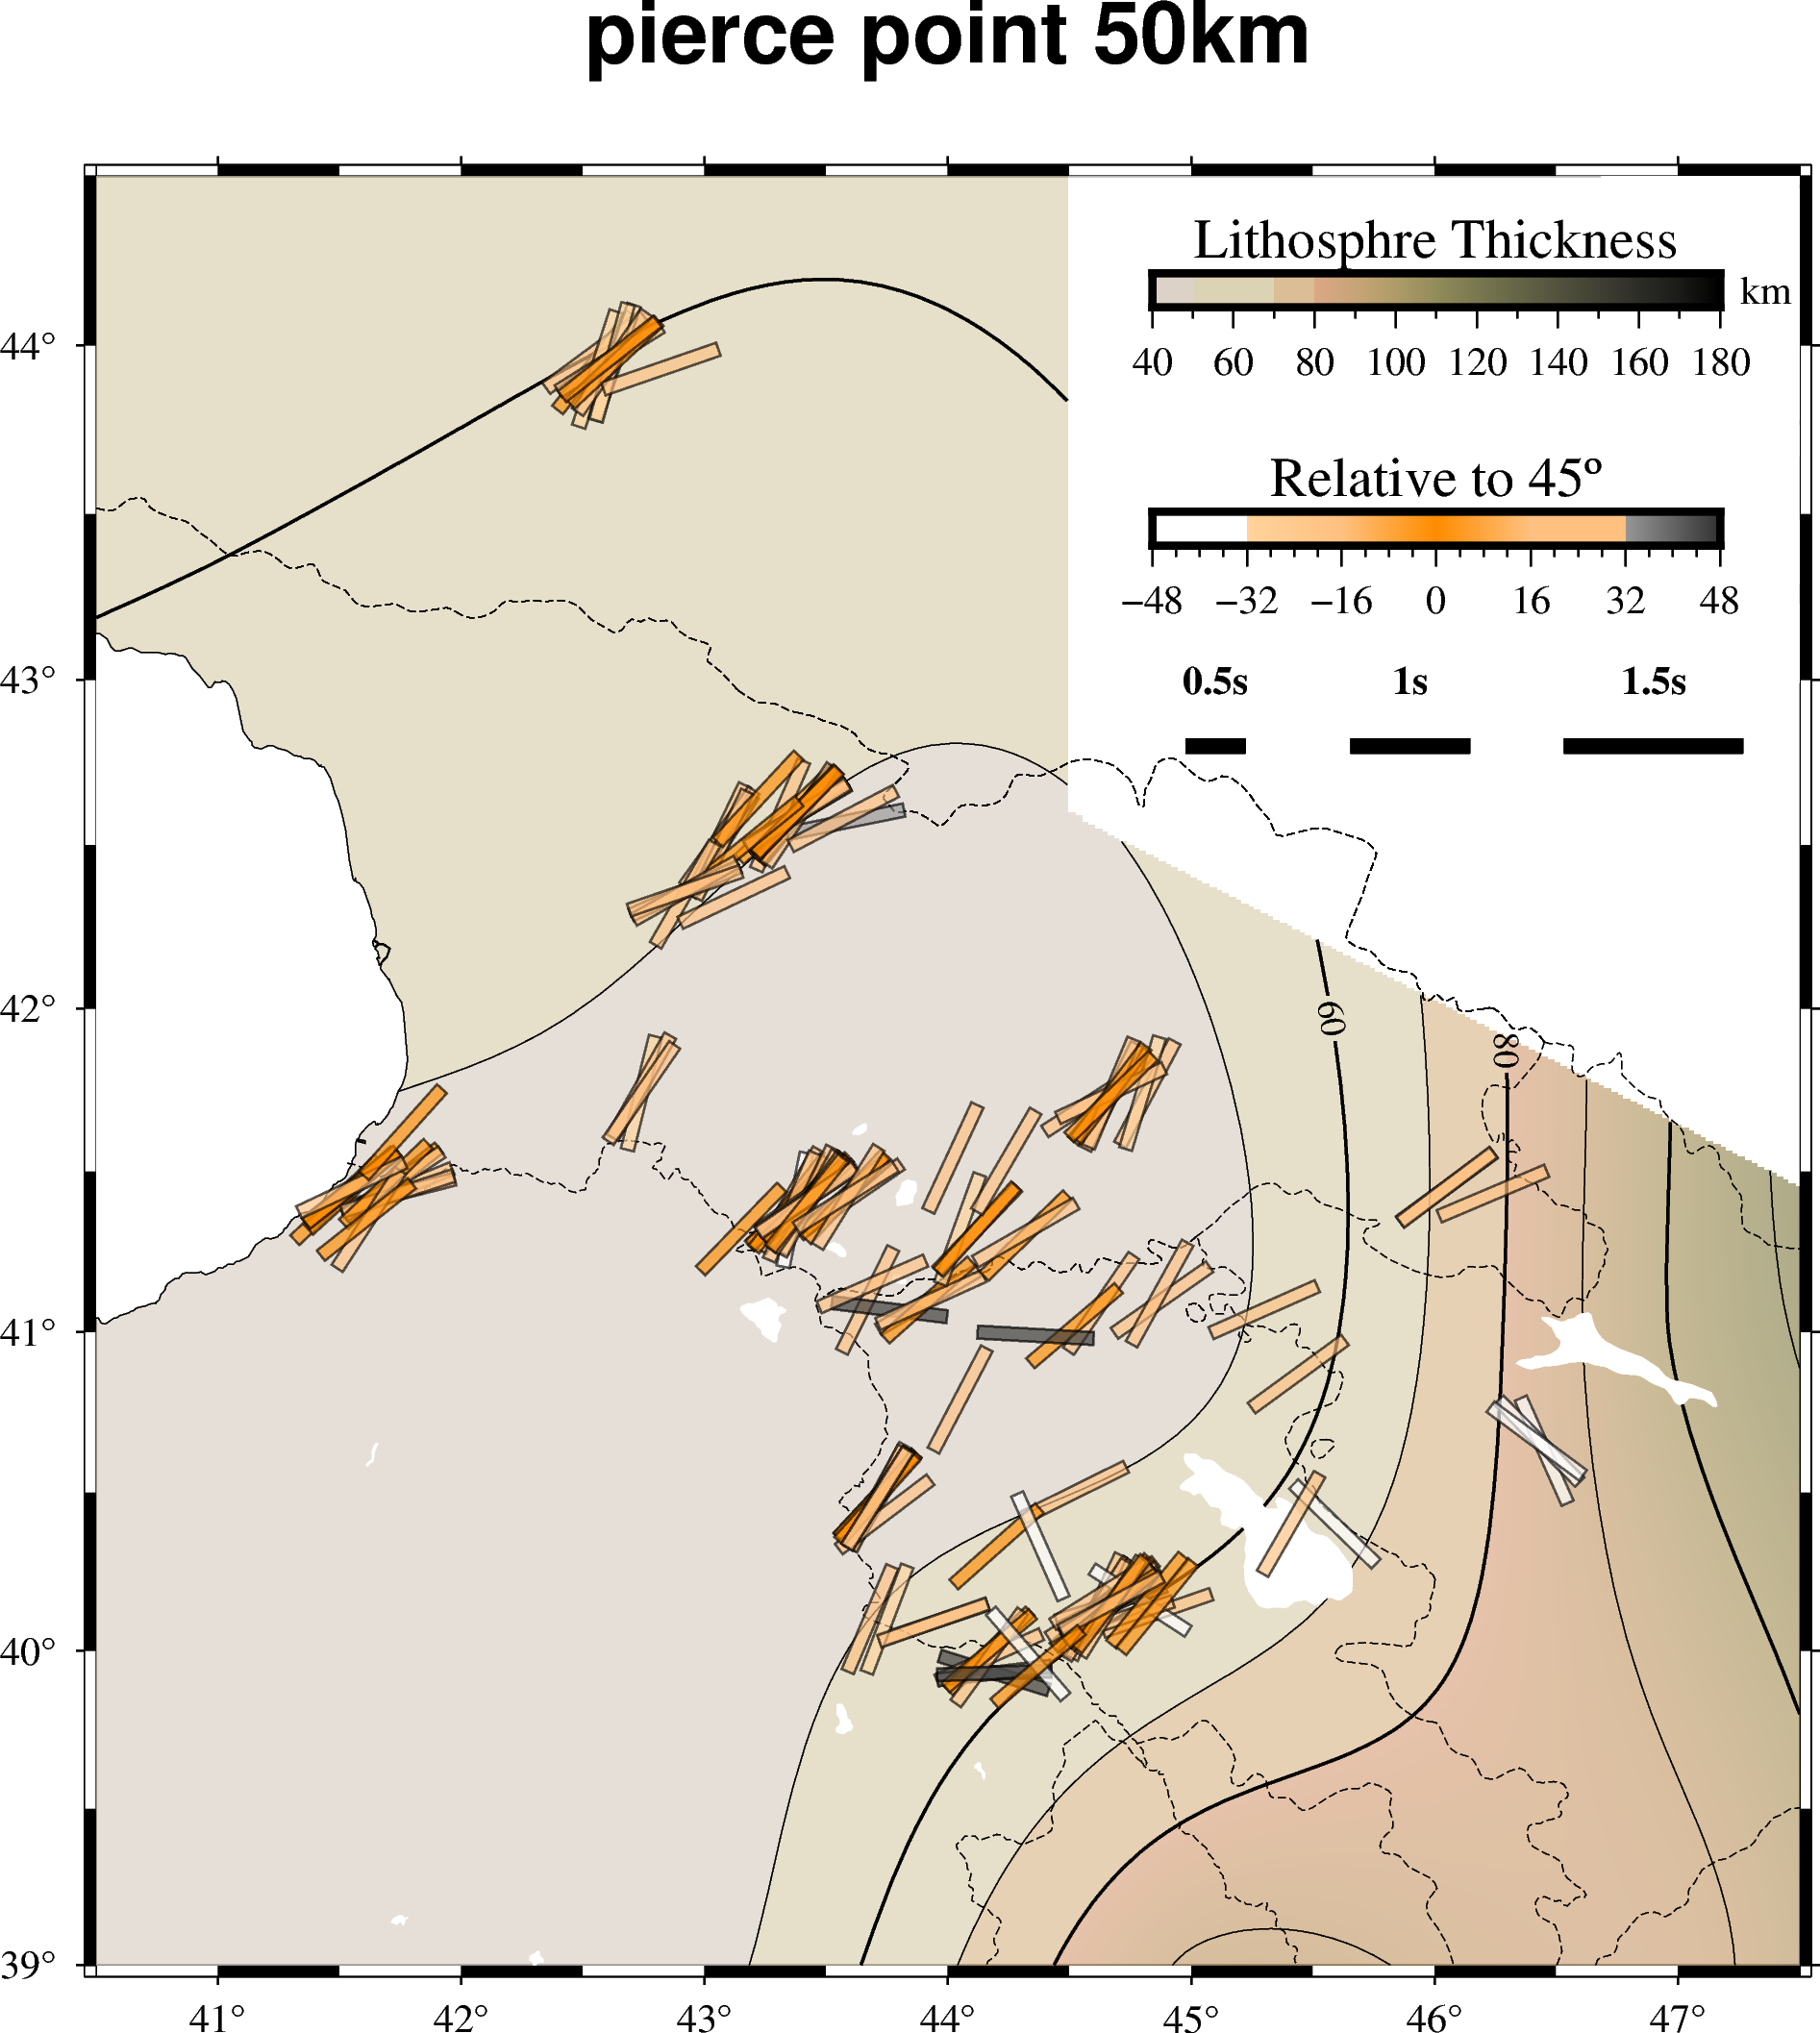

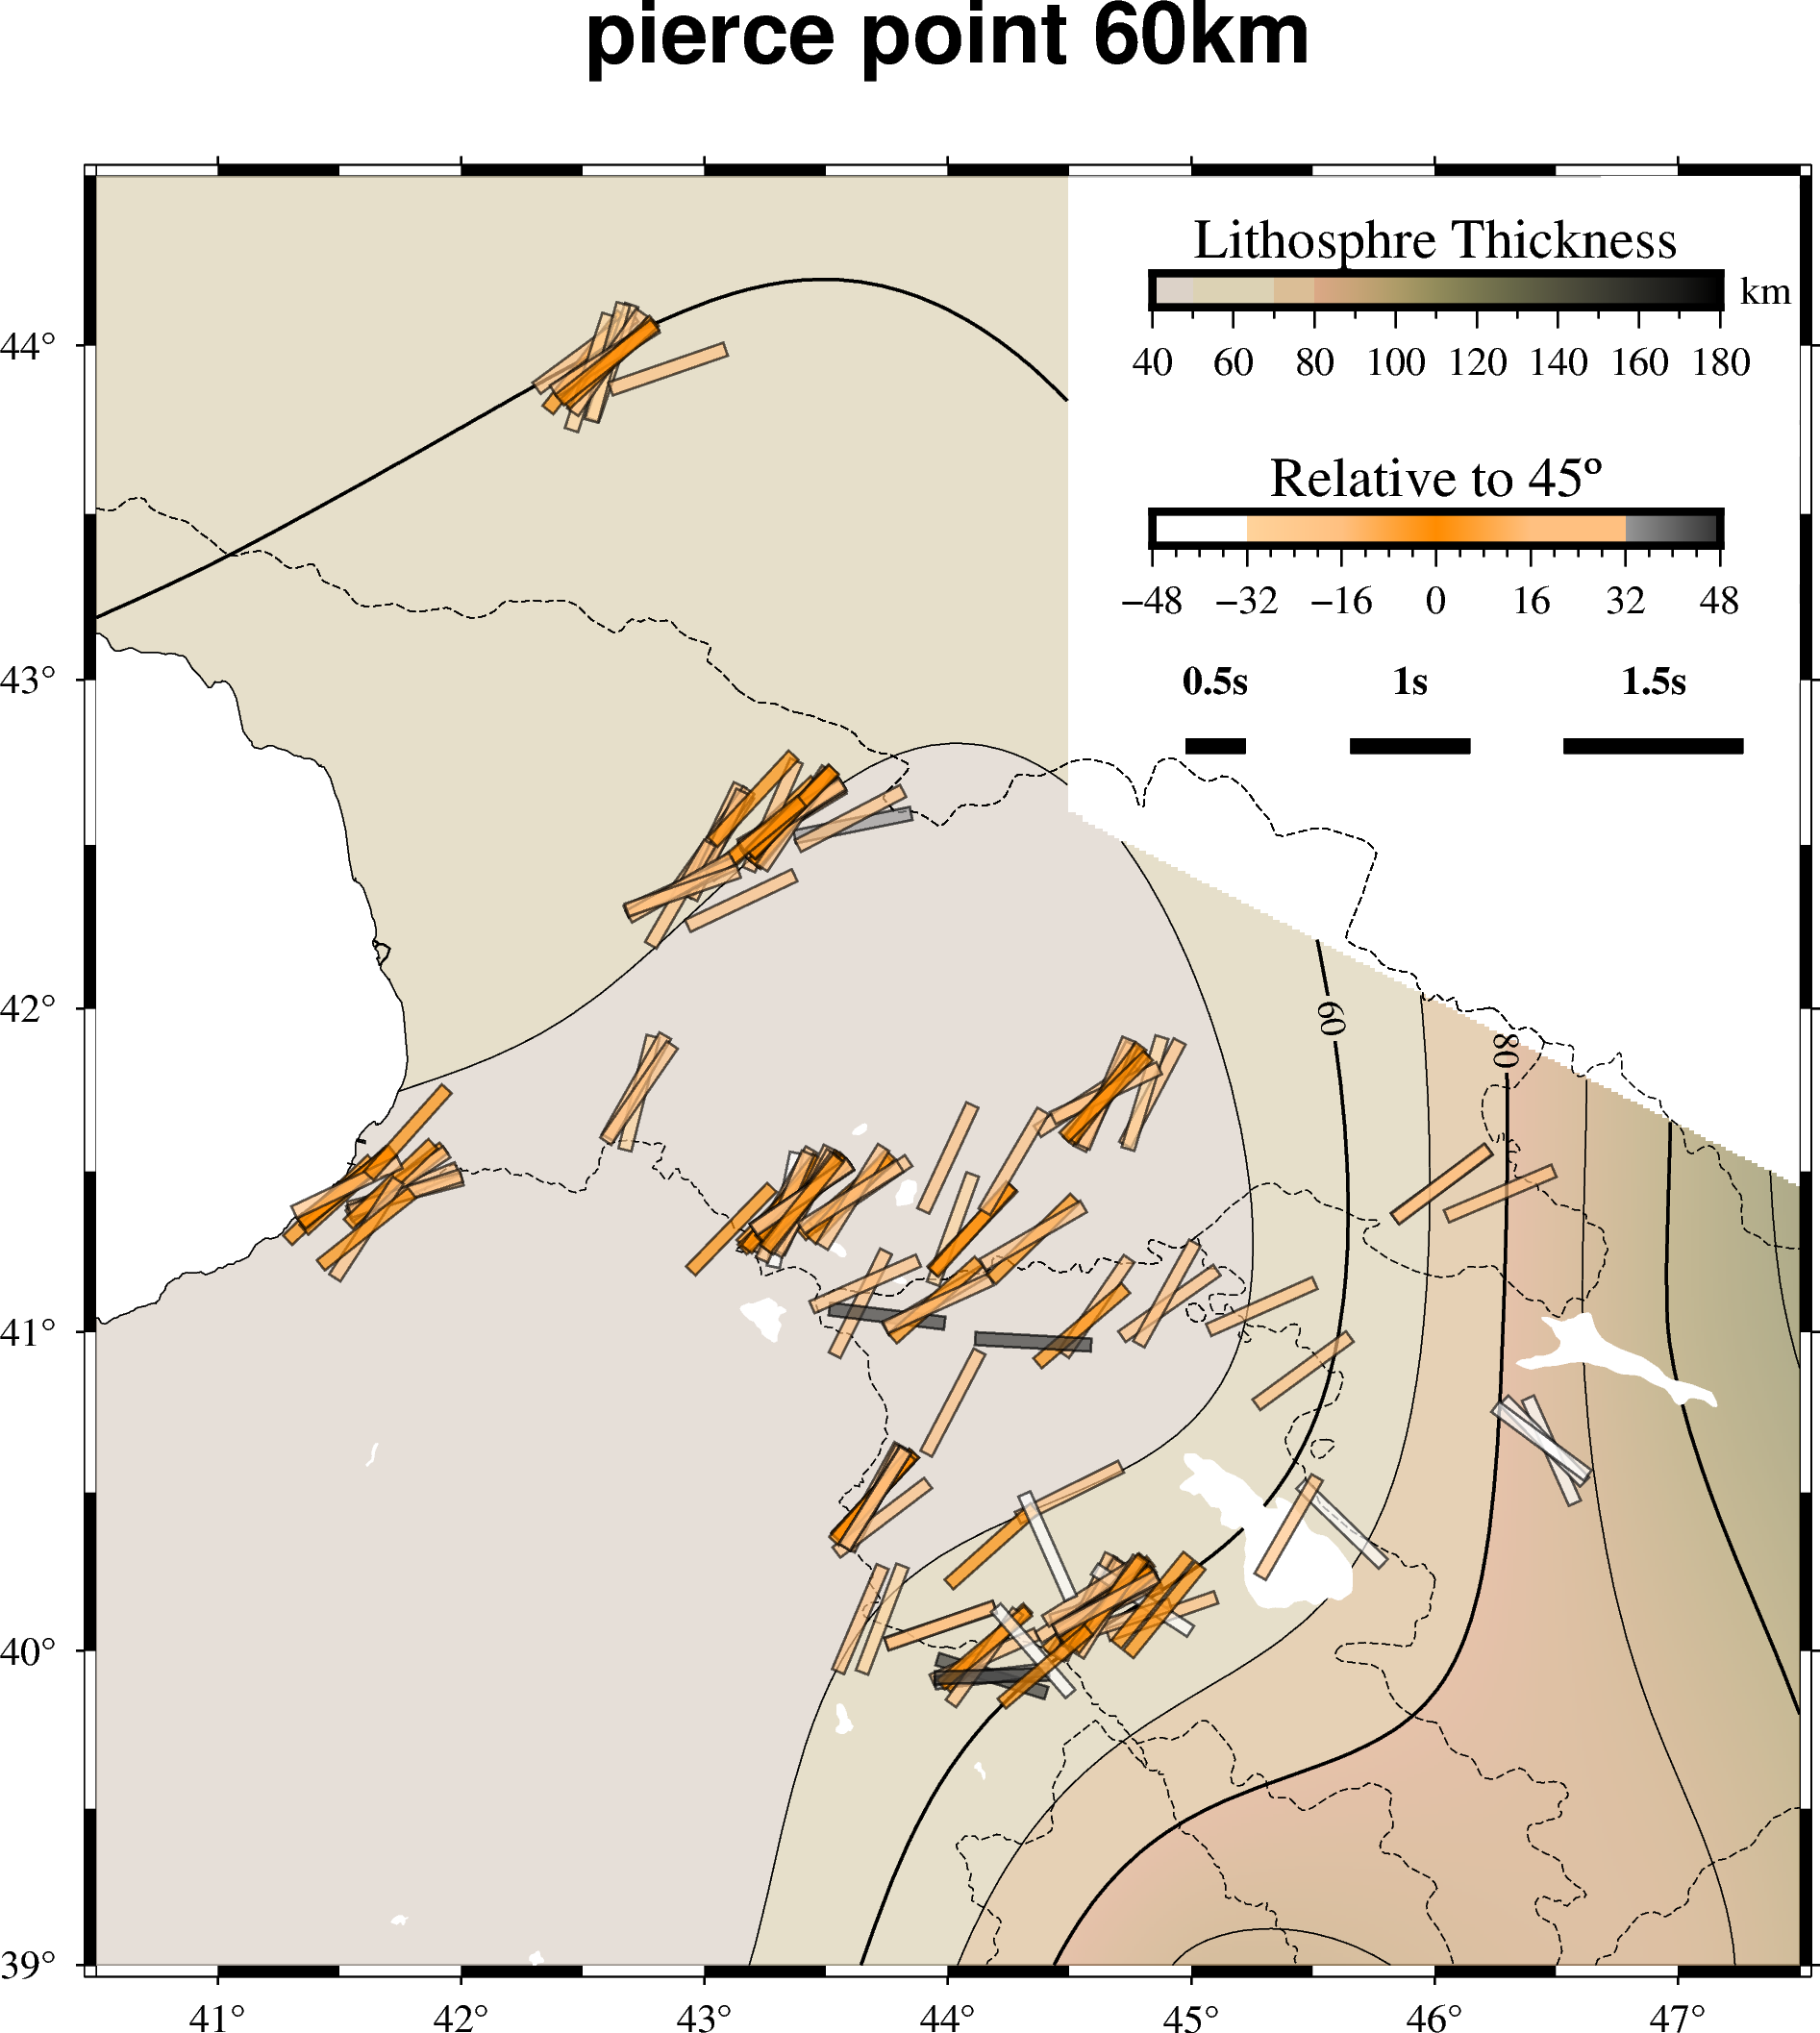

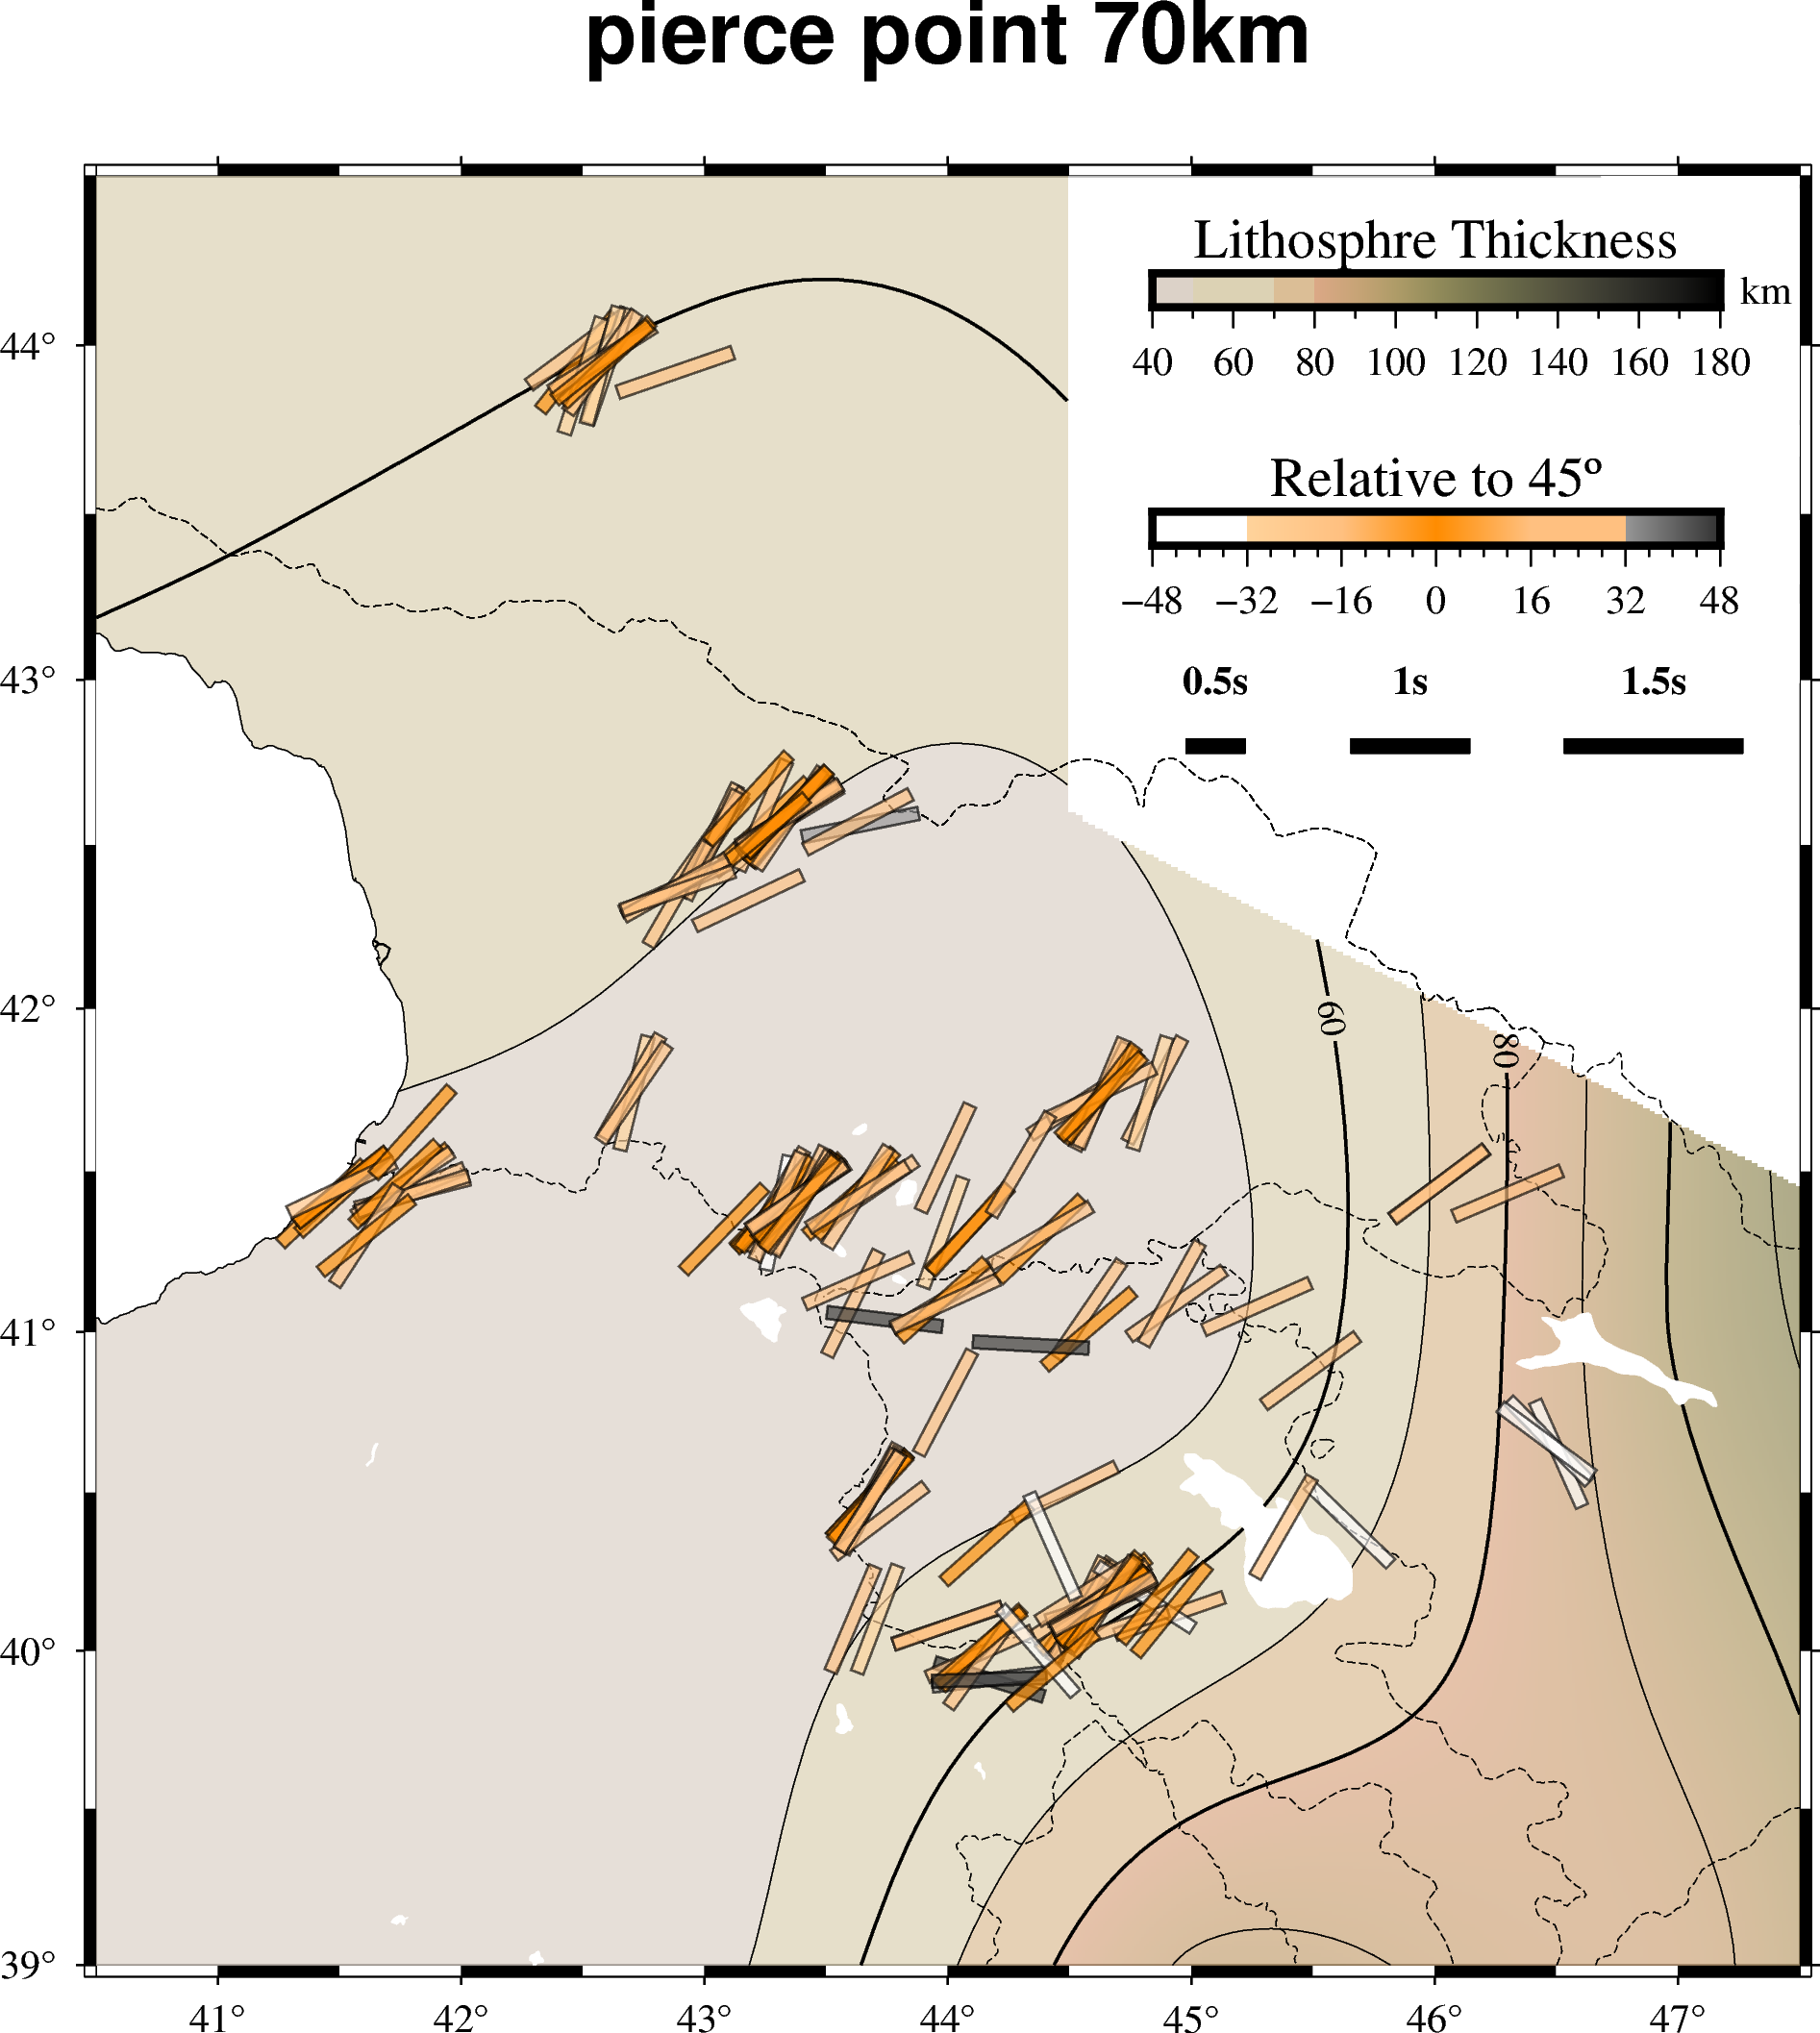

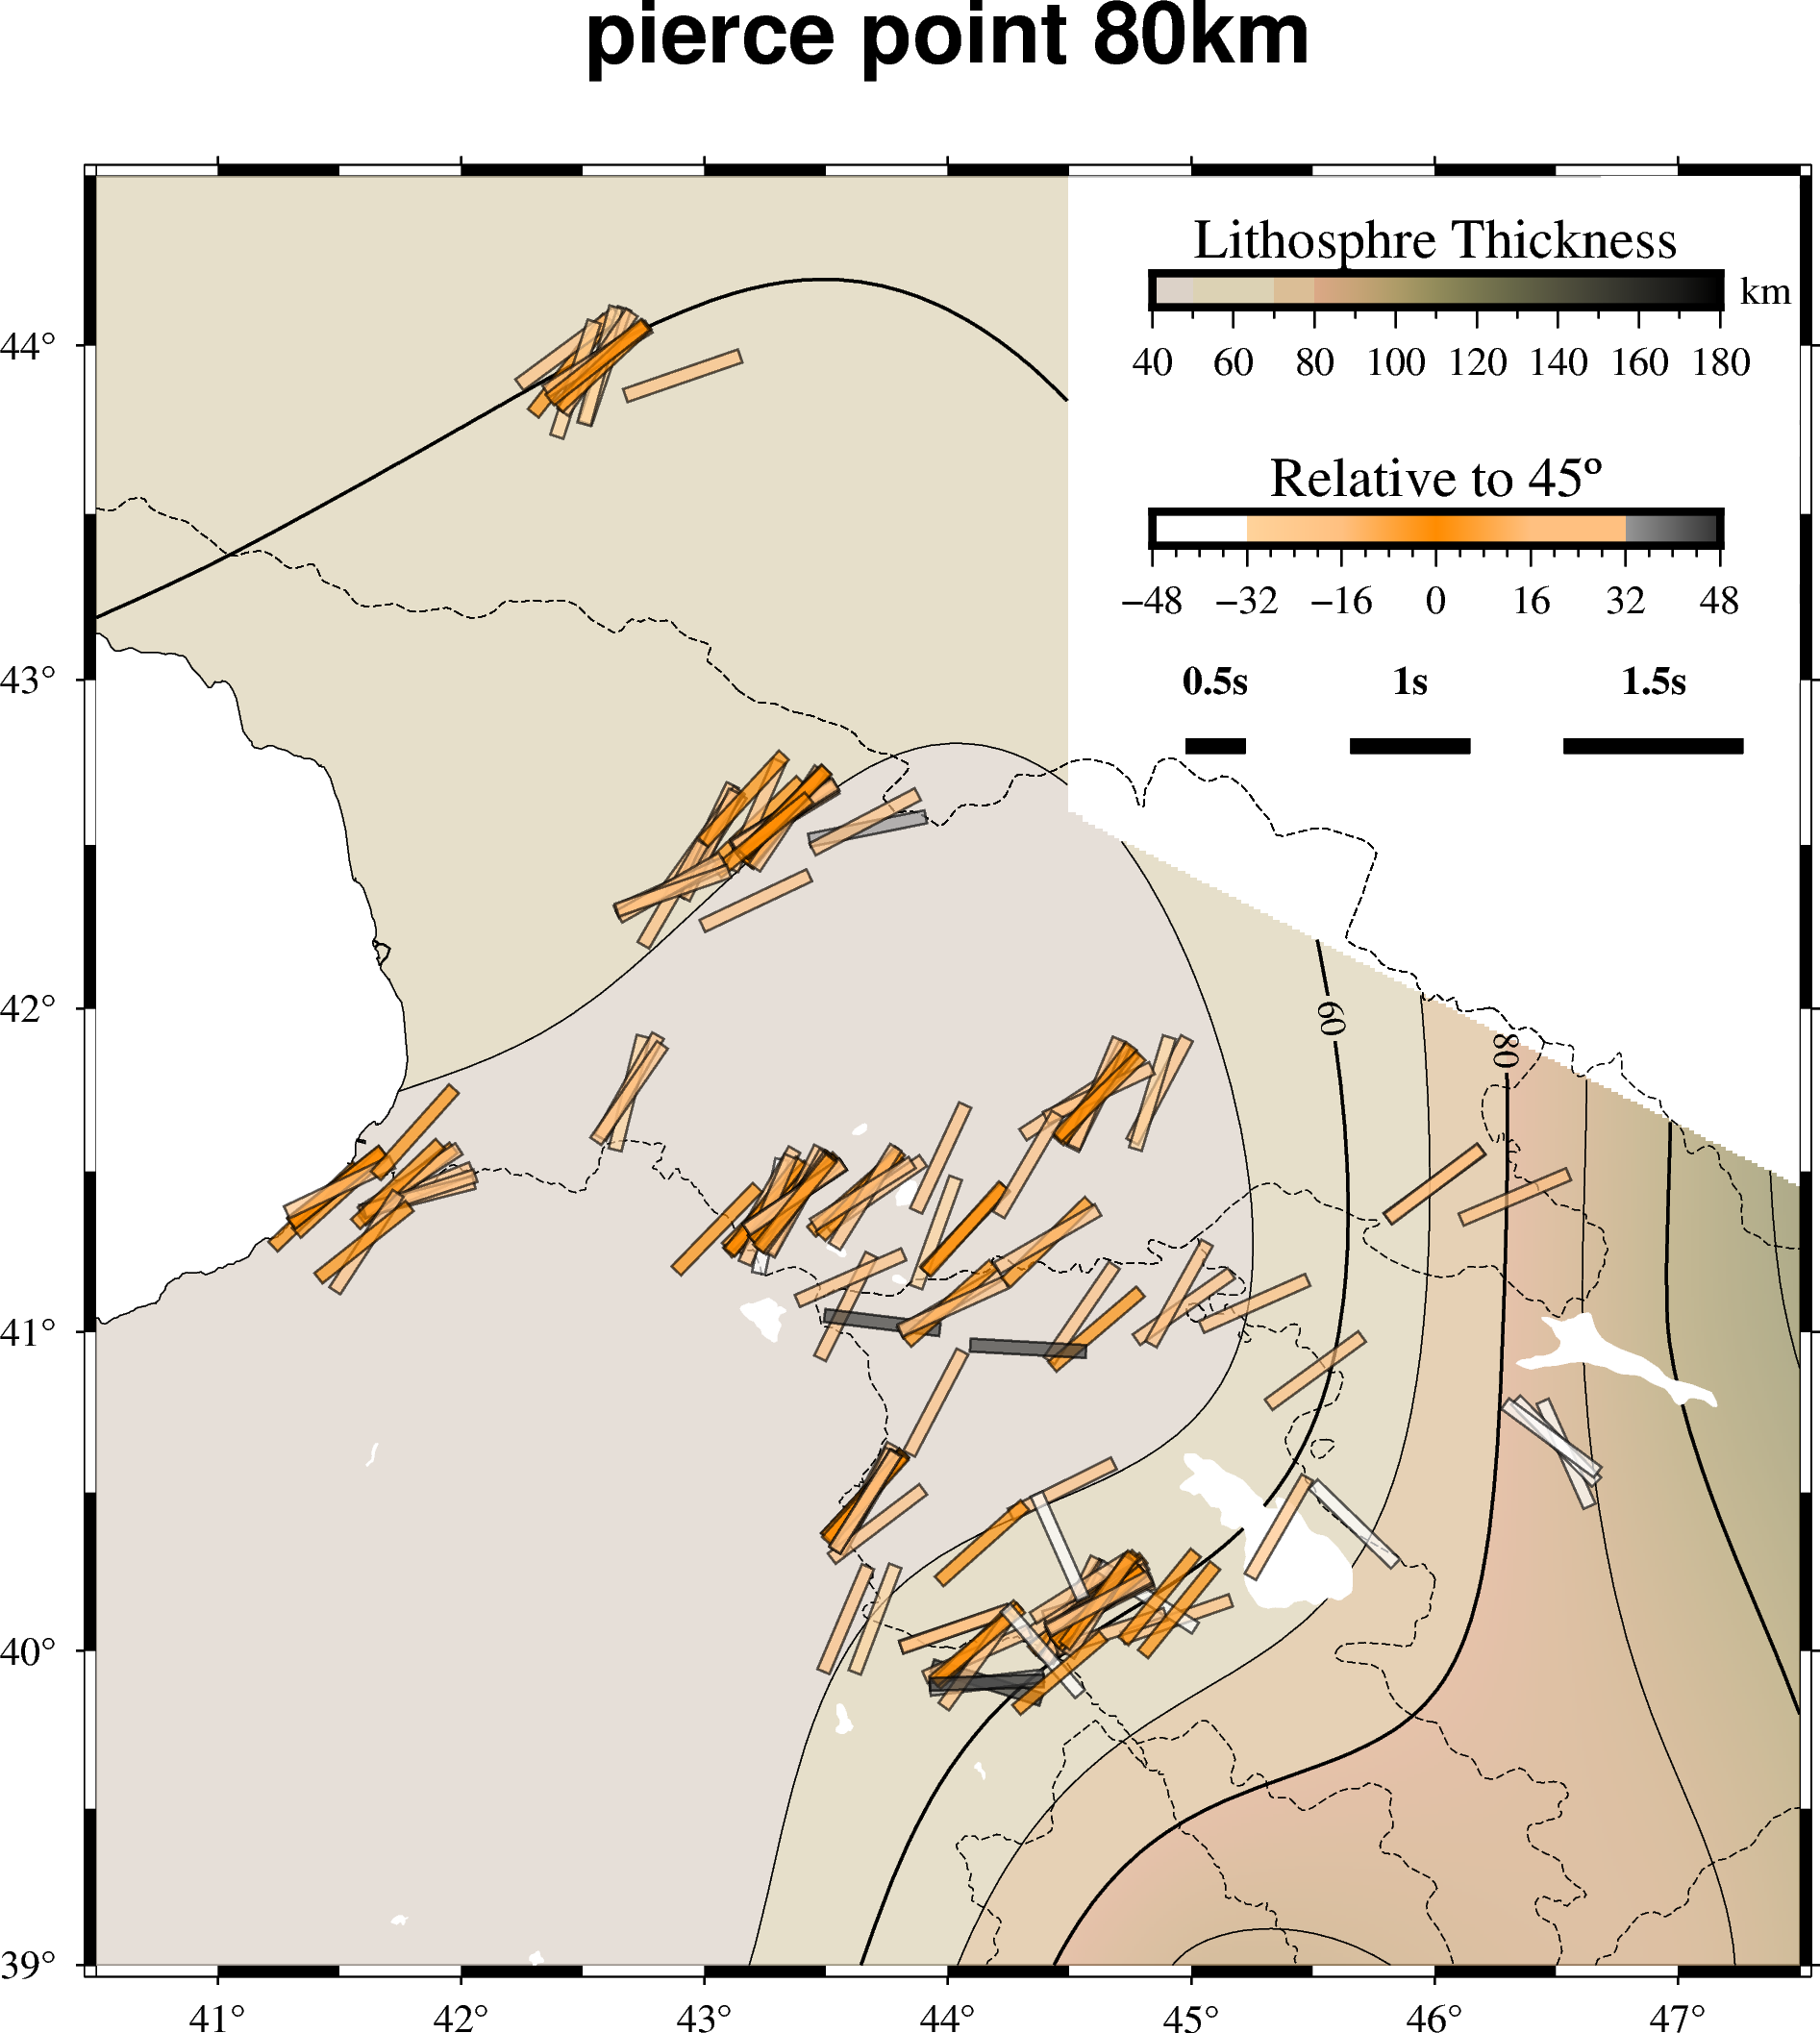

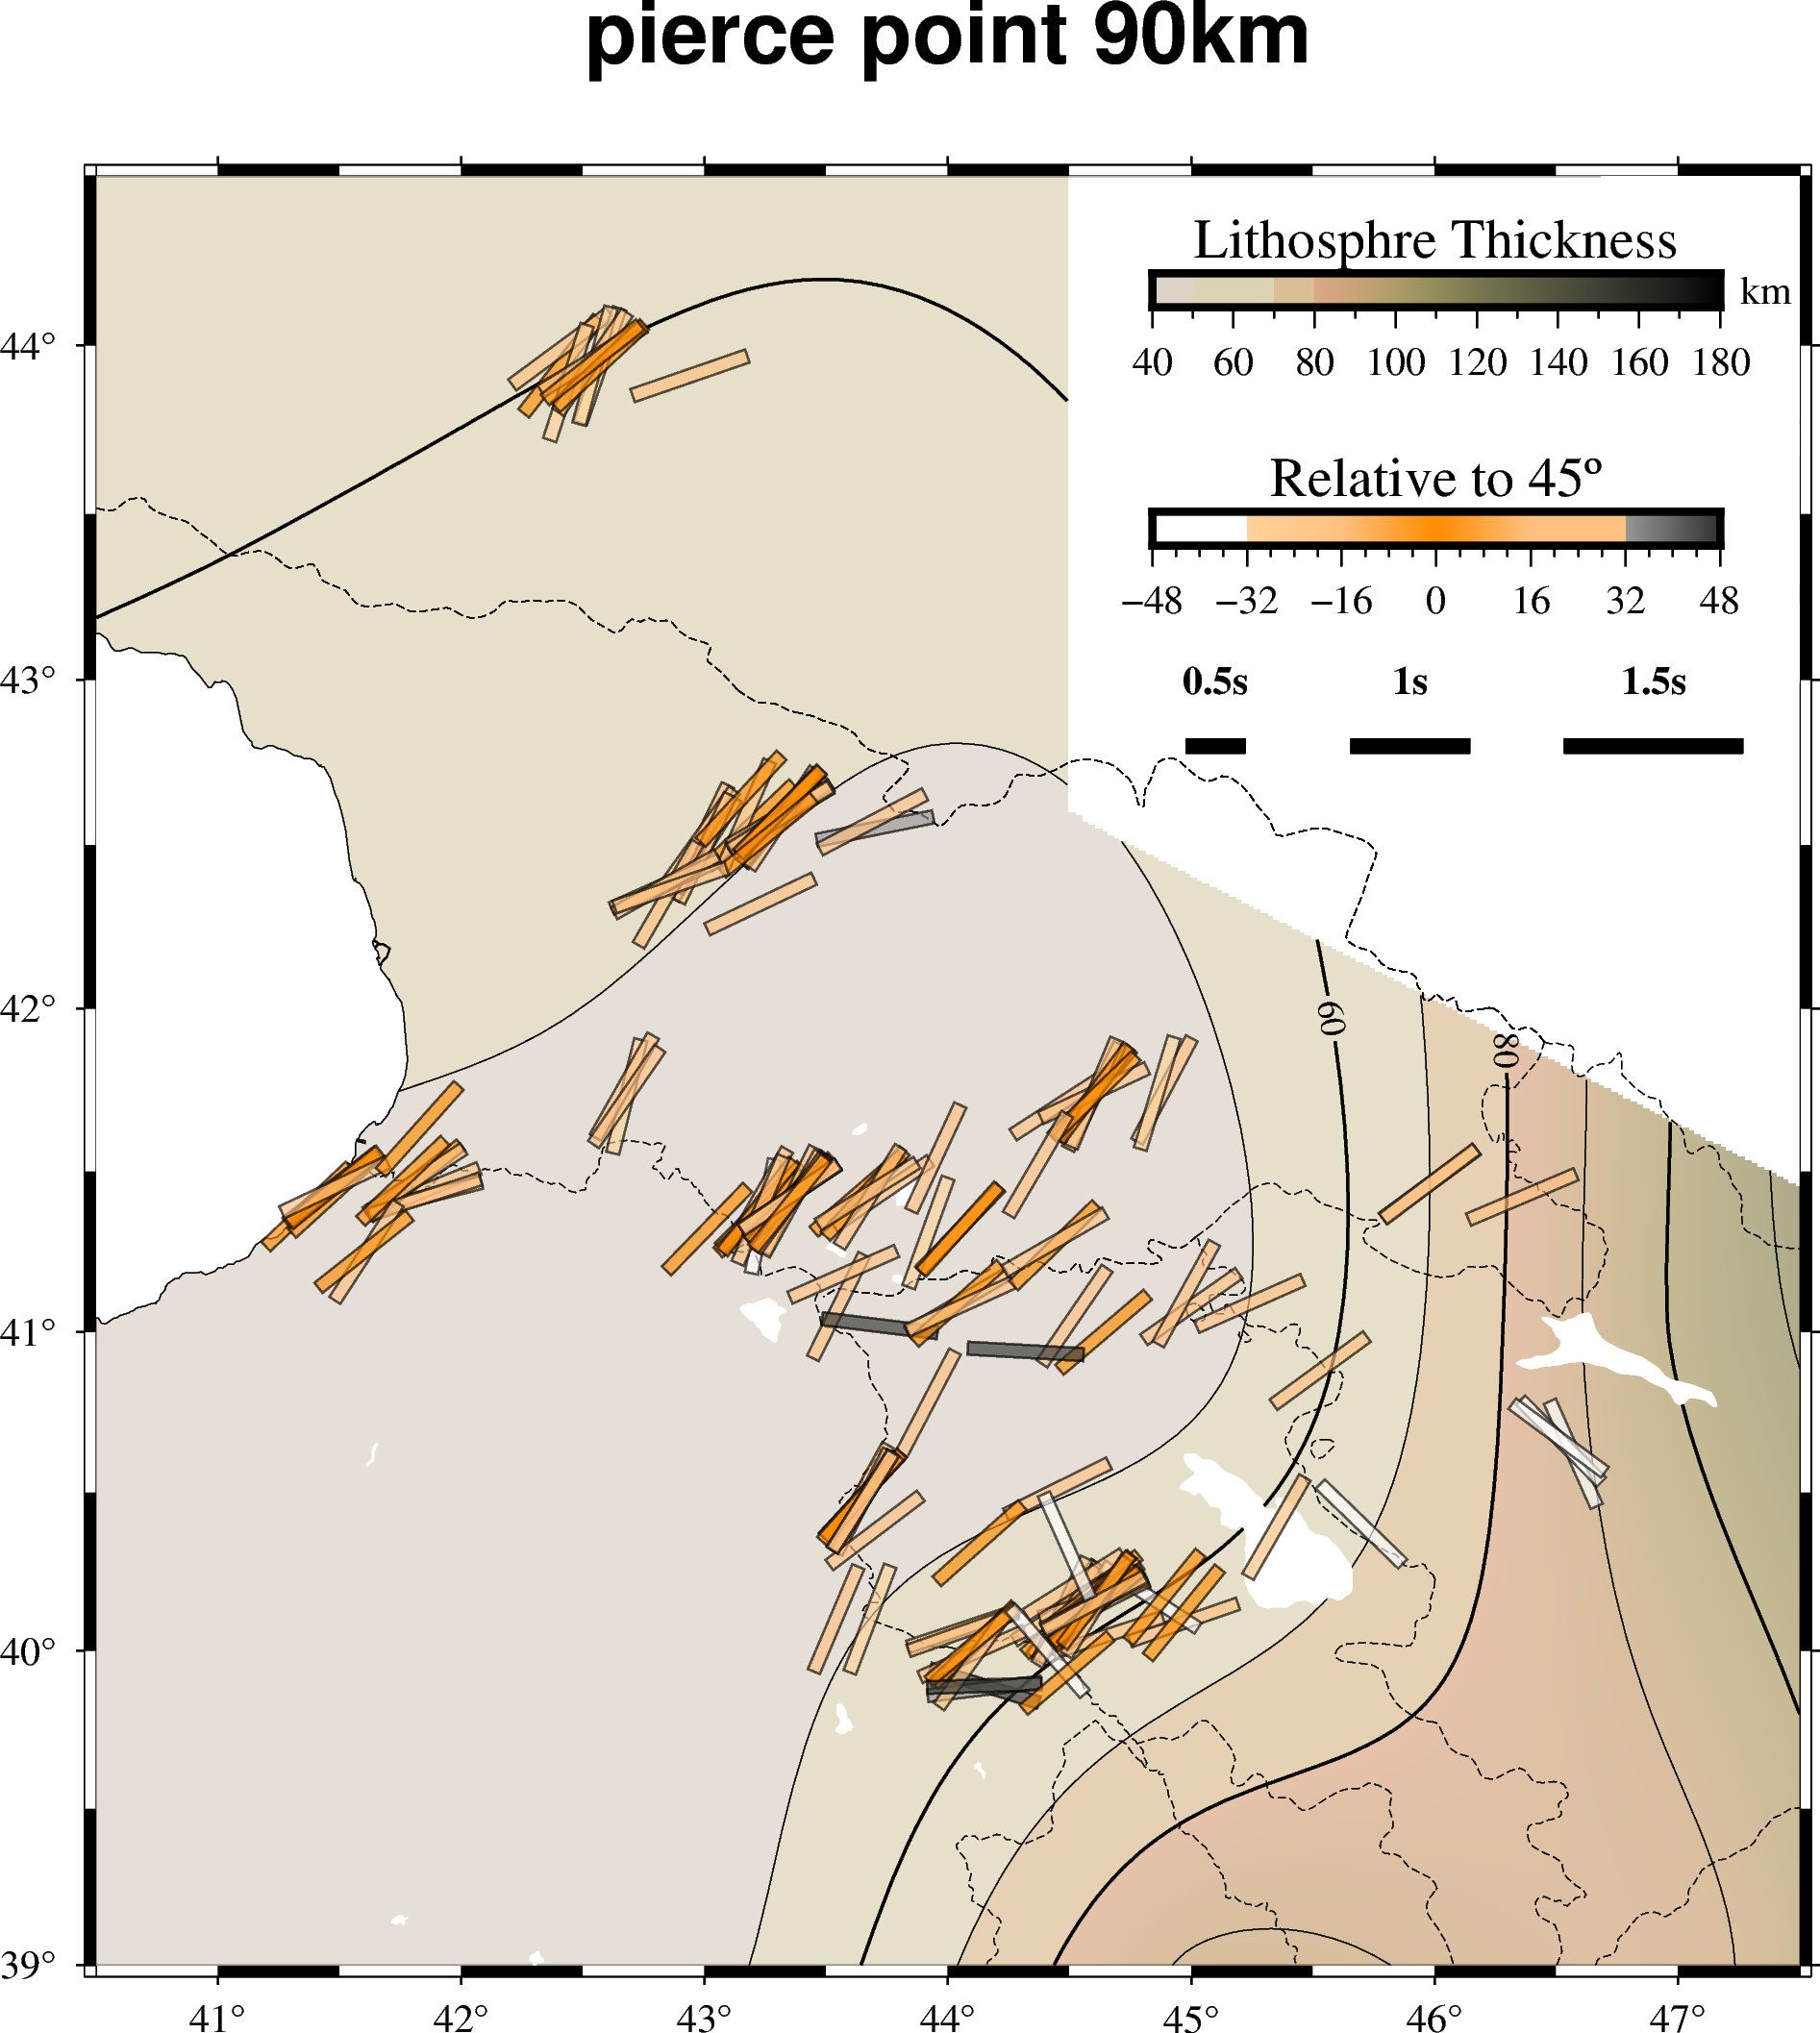

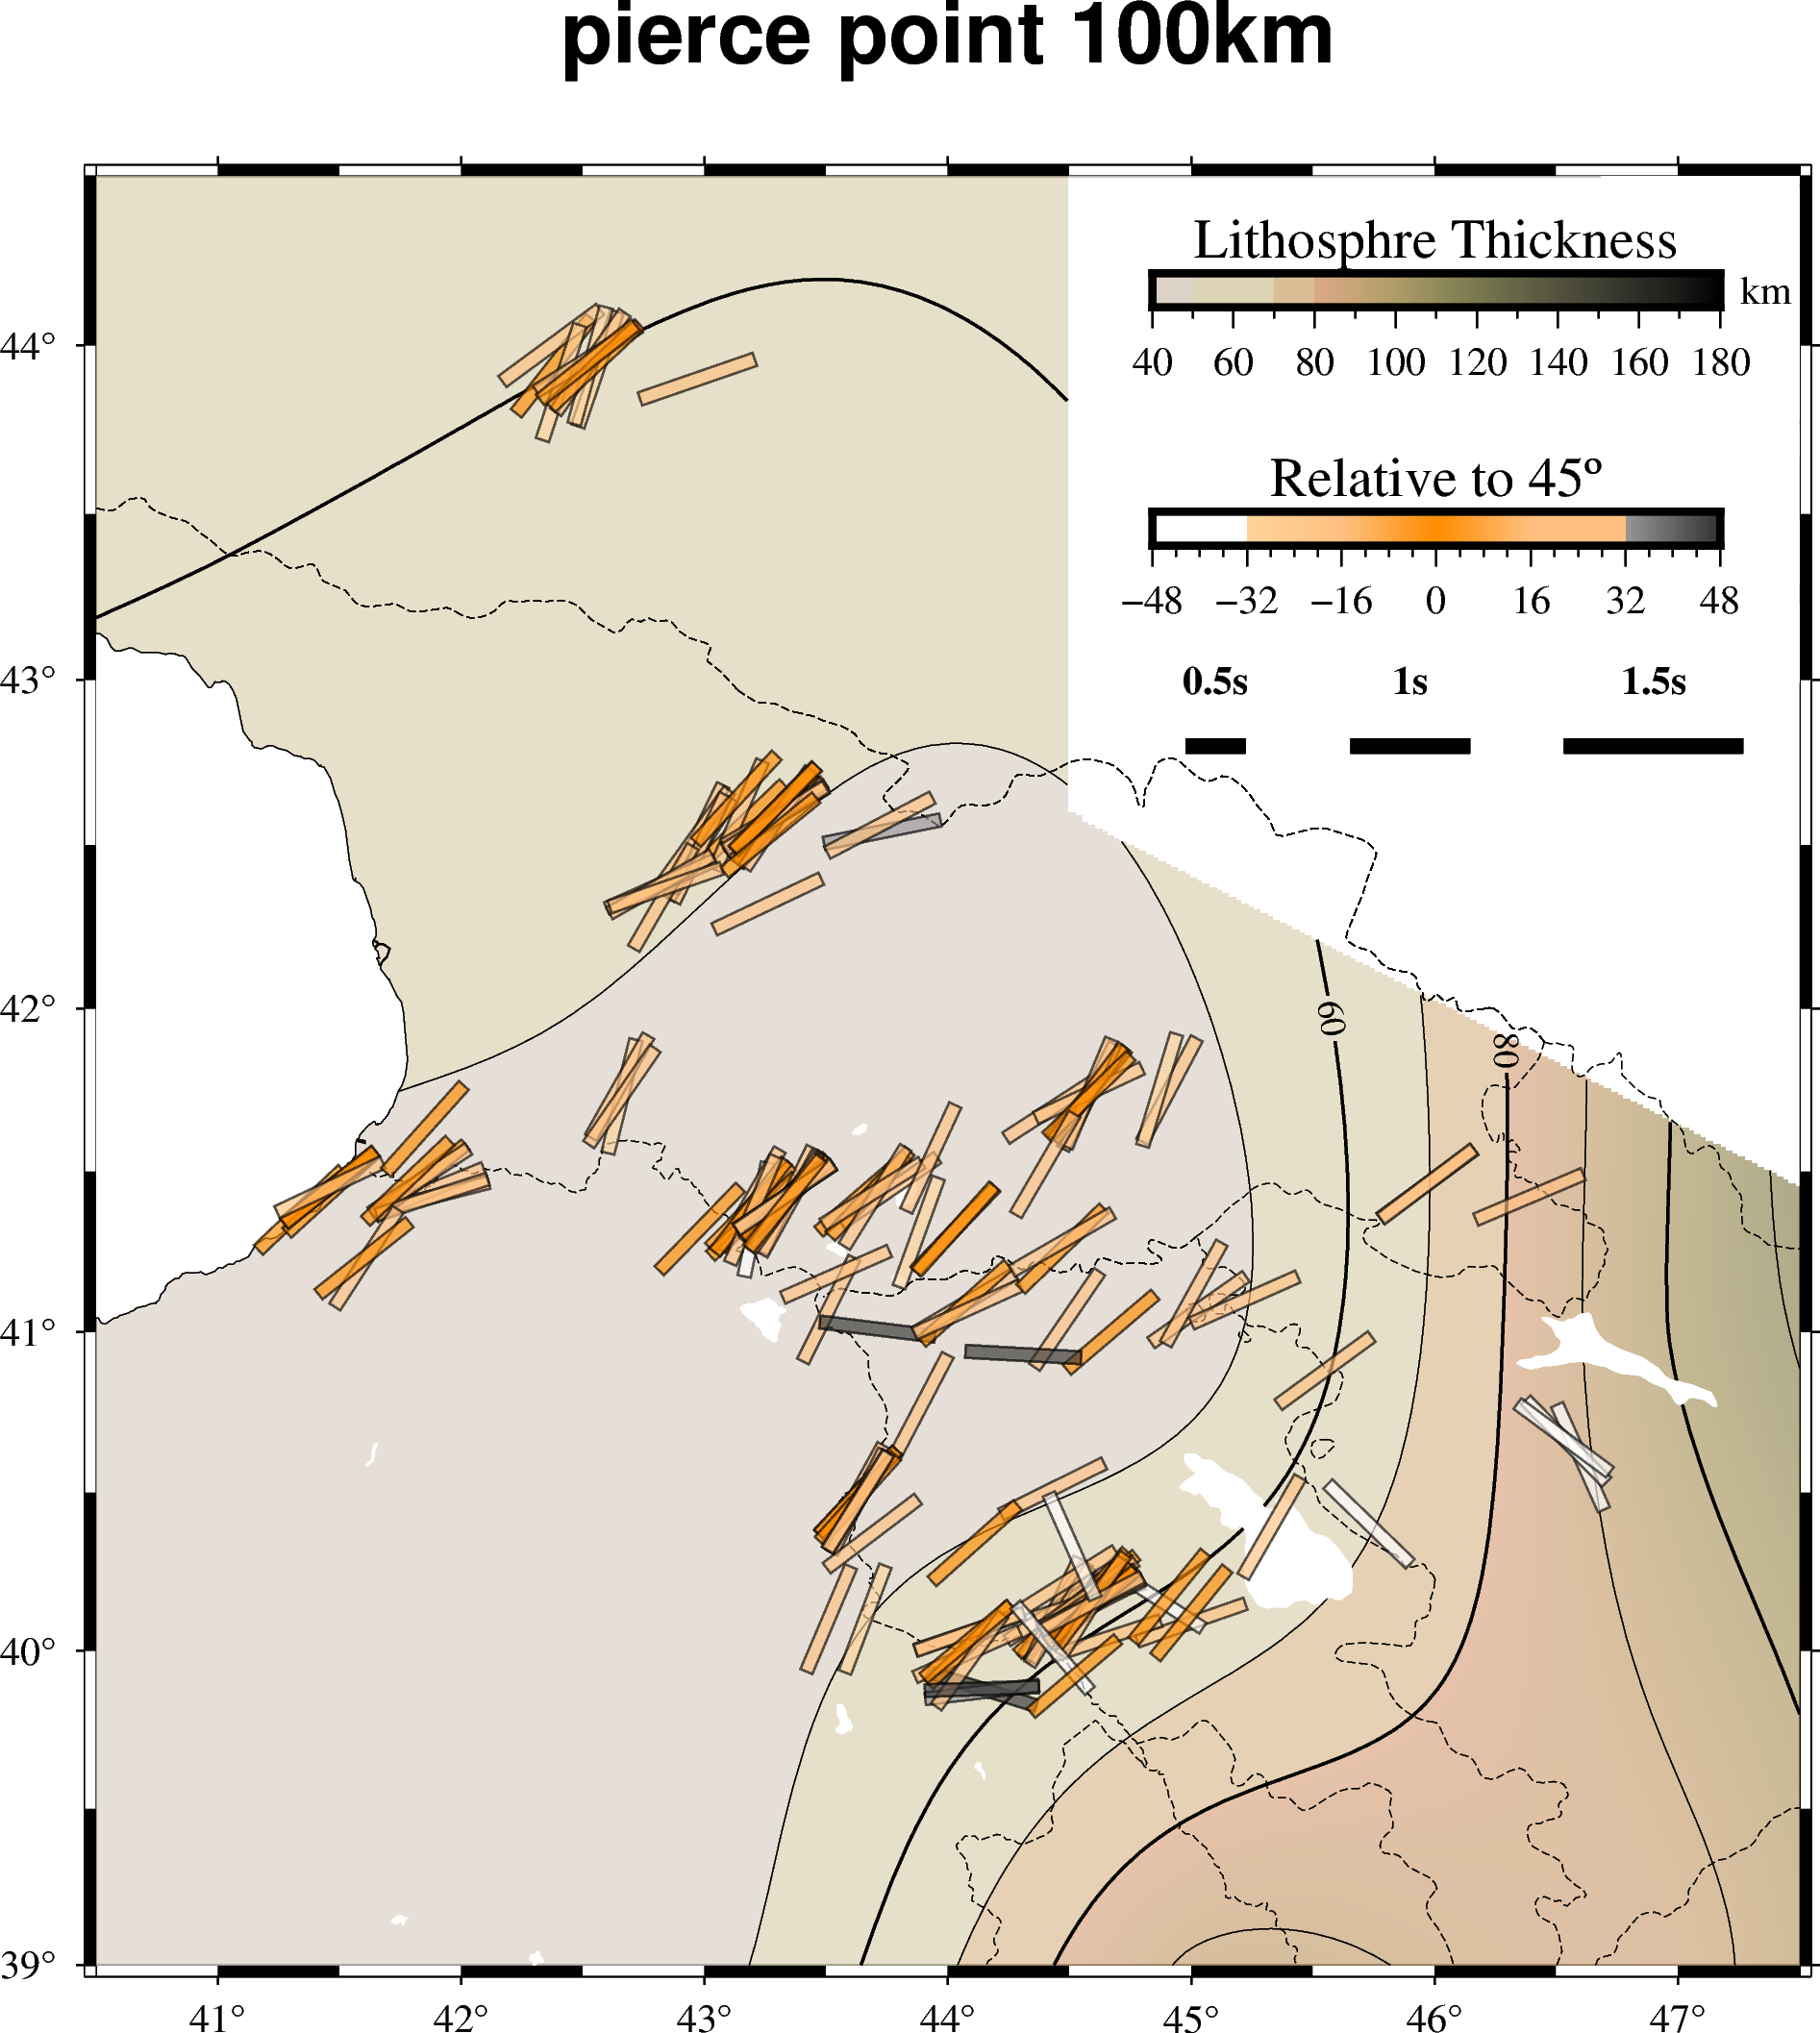

In [44]:
region = [40.5, 47.5, 39, 44.5] ##for all
fig = 'All'


for PierceDep in [50,60,70,80,90,100]:

    figmap = pygmt.Figure()
    title = f"pierce point {PierceDep}km"
    PygmtBegin(figmap,region,title)
    figmap.colorbar(cmap=colorcmp, position="x9.3c/12.5c+w5c/0.3c+h+ml", frame=['a16f4+l"Relative to 45\\353"'] )
    
    csvfile = f'PP_{PierceDep}.csv'
    df = pd.read_csv(csvfile)
    for i in range(len(df)):
        p_lon = df['plon'].values[i]
        p_lat = df['plat'].values[i]
        phi = df['phi'].values[i]
        dt  = df['dt'].values[i]

        cc = find_relcolor(phi)     

        data = [[p_lon, p_lat, phi-90, 4.5, 1*40]]
        figmap.plot(data=data, style="J", color=cc, pen="0.5p,black",transparency=35, no_clip=True)
                                       
    figmap.show()
    figmap.savefig(f'Dep{PierceDep}_wLith_fixeddt_v0.png',dpi=200)
    figmap.savefig(f'Dep{PierceDep}_wLith_fixeddt_v0.pdf',dpi=200)
    
      
    
            

        